# Lecture 3 Basic Models in Tensorflow
## Review
**TensorFlow separates definition of computations from their execution**  
- Phase 1: assemble a graph
- Phase 2: use a session to execute operations in the graph.  

**tf.constant and tf.Variable**  
- Constant values are stored in the graph definition
- Sessions allocate memory to store variable values

**tf.placeholder and feed_dict**  
- Feed values into placeholders with a dictionary (feed_dict)
- Easy to use but poor performance

**Avoid lazy loading**  
- Separate the assembling of graph and executing ops
- Use Python attribute to ensure a function is only loaded the first time it’s called

## Download from the class’s GitHub

https://github.com/chiphuyen/stanford-tensorflow-tutorials/blob/master/examples/03_linreg_starter.py

https://github.com/chiphuyen/stanford-tensorflow-tutorials/blob/master/examples/03_logreg_starter.py

https://github.com/chiphuyen/stanford-tensorflow-tutorials/blob/master/examples/utils.py

https://github.com/chiphuyen/stanford-tensorflow-tutorials/blob/master/examples/data/birth_life_2010.txt

## Linear Regression in TensorFlow

[google public data](https://www.google.com/publicdata/explore?ds=d5bncppjof8f9_&ctype=b&strail=false&nselm=s&met_x=sp_dyn_le00_in&scale_x=lin&ind_x=false&met_y=sp_dyn_tfrt_in&scale_y=lin&ind_y=false&met_s=sp_pop_totl&scale_s=lin&ind_s=false&dimp_c=country:region&ifdim=country&iconSize=0.5&uniSize=0.035#!ctype=b&strail=false&bcs=d&nselm=s&met_x=sp_dyn_le00_in&scale_x=lin&ind_x=false&met_y=sp_dyn_tfrt_in&scale_y=lin&ind_y=false&met_s=sp_pop_totl&scale_s=lin&ind_s=false&dimp_c=country:region&idim=country:CHN&ifdim=country&pit=-128419200000&hl=zh_CN&dl=zh_CN&ind=false)
<img src='picture/birth_life.gif'>

**World Development Indicators dataset**  
- X: birth rate  
- Y: life expectancy  
- 190 countries  

**Goal:**
- Find a linear relationship between X and Y to predict Y from X

**Model:**  
- Inference: $Y\_predicted = w*X + b$  
- Mean squared error: $E[(y - y\_predicted)^2]$

## 3.1 simple linear regression example using placeholders

In [1]:
""" Starter code for simple linear regression example using placeholders
Created by Chip Huyen (huyenn@cs.stanford.edu)
CS20: "TensorFlow for Deep Learning Research"
cs20.stanford.edu
Lecture 03
"""
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import utils

DATA_FILE = 'data/birth_life_2010.txt'

# Step 1: read in data from the .txt file
data, n_samples = utils.read_birth_life_data(DATA_FILE)

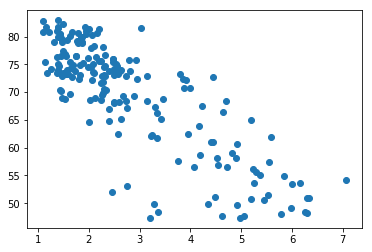

In [2]:
plt.scatter(data[:,0],data[:,1])

In [3]:
X = tf.placeholder(tf.float32, name='X')
Y = tf.placeholder(tf.float32, name='Y')

w = tf.get_variable('weights', initializer=tf.constant(0.0))
b = tf.get_variable('bias', initializer=tf.constant(0.0))

Y_predicted = w*X+b

loss=tf.square(Y_predicted-Y, name='loss')
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

In [4]:
start = time.time()
writer = tf.summary.FileWriter('./graphs/linear_reg', tf.get_default_graph())
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100):
        total_loss = 0
        for x, y in data:
            _, l = sess.run([optimizer,loss], feed_dict={X:x, Y:y})
            total_loss += l
        
        if (i+1)%20==0:
            print('Epoch {:<3d}: {:6f}'.format(i+1, total_loss/n_samples))
    w_out, b_out = sess.run([w, b])
writer.close() 
print('Took: %f seconds' %(time.time() - start))
# plt.figure(figsize=(16,8))
# plt.plot(data[:,0], data[:,1], 'bo', label='Real data')
# plt.plot(data[:,0], data[:,0] * w_out + b_out, 'r', label='Predicted data')
# plt.legend()
# plt.show()

# use 'Crtl + /' to comment or uncomment mutiple lines of code

Epoch 20 : 130.935035
Epoch 40 : 38.297009
Epoch 60 : 30.601229
Epoch 80 : 30.048283
Epoch 100: 30.035526
Took: 12.273034 seconds


<img src='picture/linreg_placeholder/annimation.gif'>

<img src='picture/linear_graph.png'>

---
**save plot figure after each epoch for gif generation**  
```python
start = time.time()
writer = tf.summary.FileWriter('./graphs/linear_reg', tf.get_default_graph())
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100):
        total_loss = 0
        for x, y in data:
            _, l = sess.run([optimizer,loss], feed_dict={X:x, Y:y})
            total_loss += l
            
        w_out, b_out = sess.run([w, b])
        plt.figure(figsize=(16,8))
        plt.plot(data[:,0], data[:,1], 'bo', label='Real data')
        plt.plot(data[:,0], data[:,0] * w_out + b_out, 'r', label='Predicted data')
        plt.ylim((45, 85))
        plt.legend()
        plt.title('epoch: '+str(i))
        plt.savefig('.\\picture\\linreg_placeholder\\epoch-'+str(i)+'.png', bbox_inches = 'tight')
        
        if (i+1)%20==0:
            print('Epoch {:<3d}: {:6f}'.format(i+1, total_loss/n_samples))
    
writer.close() 
print('Took: %f seconds' %(time.time() - start))
```
---

## 3.2 simple linear regression example using tf.data.Dataset

Epoch 20: 130.93503488078713
Epoch 40: 38.297008645340895
Epoch 60: 30.60122861903357
Epoch 80: 30.04828310612785
Epoch 100: 30.03552558278714
w: -6.070214, b: 84.929512
Took: 8.626571 seconds


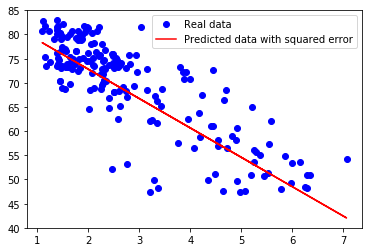

In [5]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import utils

tf.reset_default_graph()

DATA_FILE = 'data/birth_life_2010.txt'

# Step 1: read in the data
data, n_samples = utils.read_birth_life_data(DATA_FILE)

# Step 2: create Dataset and iterator
dataset = tf.data.Dataset.from_tensor_slices((data[:,0], data[:,1]))

iterator = dataset.make_initializable_iterator()
X, Y = iterator.get_next()

# Step 3: create weight and bias, initialized to 0
w = tf.get_variable('weights', initializer=tf.constant(0.0))
b = tf.get_variable('bias', initializer=tf.constant(0.0))

# Step 4: build model to predict Y
Y_predicted = X * w + b

# Step 5: use the square error as the loss function
loss = tf.square(Y - Y_predicted, name='loss')
# loss = utils.huber_loss(Y, Y_predicted)

# Step 6: using gradient descent with learning rate of 0.001 to minimize loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

start = time.time()
with tf.Session() as sess:
    # Step 7: initialize the necessary variables, in this case, w and b
    sess.run(tf.global_variables_initializer()) 
    writer = tf.summary.FileWriter('./graphs/linear_reg_withdataset', sess.graph)
    
    # Step 8: train the model for 100 epochs
    for i in range(100):
        sess.run(iterator.initializer) # initialize the iterator
        total_loss = 0
        try:
            while True:
                _, l = sess.run([optimizer, loss]) 
                total_loss += l
        except tf.errors.OutOfRangeError:
            pass
        if (i+1)%20==0:
            print('Epoch {0}: {1}'.format(i+1, total_loss/n_samples))

    # close the writer when you're done using it
    writer.close() 
    
    # Step 9: output the values of w and b
    w_out, b_out = sess.run([w, b]) 
    print('w: %f, b: %f' %(w_out, b_out))
print('Took: %f seconds' %(time.time() - start))

# plot the results
plt.plot(data[:,0], data[:,1], 'bo', label='Real data')
plt.plot(data[:,0], data[:,0] * w_out + b_out, 'r', label='Predicted data with squared error')
# plt.plot(data[:,0], data[:,0] * (-5.883589) + 85.124306, 'g', label='Predicted data with Huber loss')
plt.legend()
plt.show()

## Huber loss
- Robust to outliers
- If the difference between the predicted value and the real value is small, square it
- If it’s large, take its absolute value  
$L_\delta(y,f(x))=\begin{cases}
\frac{1}{2}(y-f(x)), & for \left|y-f(x)\right|\leq\delta,  \\
\delta\left|y-f(x)\right|-\frac{1}{2}\delta^2, & otherwise.
\end{cases}$  


**Implementing Huber loss**  
**Can’t write ( You can write it if eager mode were enabled. ):**  
```python
if y - y_predicted < delta:
```
**use:**
```python
tf.cond(pred, fn1, fn2, name=None)

def huber_loss(labels, predictions, delta=14.0):
    residual = tf.abs(labels - predictions)
    def f1(): return 0.5 * tf.square(residual)
    def f2(): return delta * residual - 0.5 * tf.square(delta)
    return tf.cond(residual < delta, f1, f2)
```  

**TF Control Flow**
```python
Control Flow Ops  tf.group, tf.count_up_to, tf.cond, tf.case, tf.while_loop, ...
Comparison Ops    tf.equal, tf.not_equal, tf.less, tf.greater, tf.where, ...     
Logical Ops       tf.logical_and, tf.logical_not, tf.logical_or, tf.logical_xor  
Debugging Ops     tf.is_finite, tf.is_inf, tf.is_nan, tf.Assert, tf.Print, ...   
```  
Since TF builds graph before computation, we haveto specify all possible subgraphs beforehand.  
PyTorch’s dynamic graphs and TF’s eager executionhelp overcome this

## tf.data
Instead of doing inference with placeholders and feeding in data later, do inference directly with data
```python
tf.data.Dataset
tf.data.Iterator
```
**Store data in tf.data.Dataset**  
```python
tf.data.Dataset.from_tensor_slices((features, labels))
dataset = tf.data.Dataset.from_tensor_slices((data[:,0], data[:,1]))

tf.data.Dataset.from_generator(gen, output_types, output_shapes)

tf.data.TextLineDataset(filenames)
tf.data.FixedLengthRecordDataset(filenames)
tf.data.TFRecordDataset(filenames)
```
## tf.data.Iterator
Create an iterator to iterate through samples in Dataset  

**Iterates through the dataset exactly once. No need to initialization.**  
```python
iterator = dataset.make_one_shot_iterator()  
```
       
**Iterates through the dataset as many times as we want. Need to initialize with each epoch.**
```python
iterator = dataset.make_initializable_iterator()  
```

**example1:**
```python
iterator = dataset.make_one_shot_iterator()
X, Y = iterator.get_next() # X is the birth rate, Y is the life expectancy
with tf.Session() as sess:
    print(sess.run([X, Y])) # >> [1.822, 74.82825]
    print(sess.run([X, Y])) # >> [3.869, 70.81949]
    print(sess.run([X, Y])) # >> [3.911, 72.15066]
```

**example2:**
```python
iterator = dataset.make_initializable_iterator()
...
for i in range(100):
    sess.run(iterator.initializer)
    total_loss = 0
    try:
        while True:
            sess.run([optimizer])
    except tf.errors.OutOfRangeError:
        pass
```

### Handling data in TensorFlow
```python
dataset = dataset.shuffle(1000)
dataset = dataset.repeat(100)
dataset = dataset.batch(128)
dataset = dataset.map(lambda x: tf.one_hot(x, 10))
# convert each elem of dataset to one_hot vector
```

### Does tf.data really perform better?
With placeholder: 9.05271519 seconds  
With tf.data: 6.12285947 seconds

### Should we always use tf.data?
- For prototyping, feed dict can be faster and easier to write (pythonic)
- tf.data is tricky to use when you have complicated preprocessing or multiple data sources
- NLP data is normally just a sequence of integers. In this case, transferring the data over to GPU is pretty quick, so the speedup of tf.data isn't that large

## Optimizers
```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)
_, l = sess.run([optimizer, loss], feed_dict={X: x, Y:y})
```
Session looks at all **trainable** variables that loss depends on and update them.(**weights** and **bias** below)
<img src='picture/optimizer.jpg' width='50%'>
### Trainable variables
tf.Variable(initial_value=None, **trainable**=True,...)  
Specify if a variable should be trained or not. By default, all variables are trainable
### List of optimizers in TF
```python
tf.train.GradientDescentOptimizer
tf.train.AdagradOptimizer
tf.train.MomentumOptimizer
tf.train.AdamOptimizer
tf.train.FtrlOptimizer
tf.train.RMSPropOptimizer
...
```
“Advanced” optimizers work better when tuned, but are generally harder to tune.

## Logistic Regression in TensorFlow
### MNIST Database
Each image is a 28x28 array, flattened out to be a 1-d tensor of size 784  
<img src='picture/minist.jpg'>

X: image of a handwritten digit  
Y: the digit value  
Recognize the digit in the image  

**Model:**  
Inference: $Y\_predicted = softmax(X * w + b)$  
Cross entropy loss: $-log(Y\_predicted)$